Here we will replicate the seminal work "*Reconstructing Visual Experiences from Brain Activity Evoked by Natural Movies*" (Nishimoto et al, 2011, Current Biology).


# Background

The code I will provide covers the basics of encoding-decoding. It's useful as an introductory tutorial if you are taking your work in this direction.

The objective here is to try and see if we can predict what is going on in peoples' brains just by looking at their brain activity. This is often referred to as "decoding".

To do this we need to develop a method that takes as input the brain activity and produces as an output some description of what was going on in their brains. In the paper the output was movie clips.

The experiment of Nishimoto et al is very simple. Subjects viewed a movie (the stimulus) inside an fMRI scanner. We will build a model that takes the recorded fMRI data and predicts which stimulus (which frames in the movie) it corresponds to. This can be extended to reconstruct the stimuli from scratch (which they do in the paper but I won't here as it takes a bit more work, I'll return to this in the end).

The approach has two steps.

1. Build a model that takes in the stimulus and predicts brain activity - the encoding model

2. Invert the encoding model to take in brain activity and predict the stimulus - decoding model

I will cover the experimental details as I go along, but it would be easier to follow after reading the paper, which you can find [here](https://gallantlab.org/_downloads/2011a.Nishimoto.etal.pdf).

You can run the code alongside this post using the jupyter notebook available [here](https://github.com/drorcohengithub/decoding_visual_experience)

__Note__

This is not a python nor machine learning tutorial. The point is to illustrate the high level structure of the encoding-decoding approach. I assume the reader is familiar with pythons as well as concepts such as cross validation and regularization.

# The data

The data from the paper is kindly hosted [here](https://crcns.org/data-sets/vc/vim-2/about-vim-2).
You will need to create a free account to access it.

The VoxelResponses_subject*.tar.gz files contain the fMRI data. Download and extract them.

The Stimuli.tar.gz file contains the actual stimulus (the movies) shown to the subjects. You can download and play the movies (the data is an array of frames), but we will not actually directly needs this.

## Load the data

Let's have a look at subject#1's data.

You would have noticed that the data is a .mat format, which is what MATLAB uses. We can access it using the h5py package.

The file has four fields.

- ei - contains general information about the experiment
- roi - stands for Region Of Interest. These labels tell us which part of the data belongs to what anatomical structure.
- rt - data used for the training the (encoding and decoding) models in the paper
- rv - data used for testing the models (sometime referred to as validation data, but that can be confusing when cross validation is discussed, so I will refer to this as the test data.)
- rva - data used for testing the models, *before* averaging. I will explain this later

Lets load the data

In [1]:
import h5py

In [2]:

sn_data_fld = '../Nishimoto2011Data/' #path/to/folder/with/data
# will use subject 1 here
sn_data_typ = 'VoxelResponses_subject1.mat'
sn_data_fl = sn_data_fld + sn_data_typ

# read the data
with h5py.File(sn_data_fl, 'r') as f:
    
    # these are the things we have here
    print(f.keys())
    
    # test data, before averaging across trials
    test_data = f['rva'][()]

    # test data after averaging across trials
    test_data_ave = f['rv'][()]

    # training data
    trn_data = f['rt'][()]

    print("get the roi info")
    ## ROIs 
    rois = f['roi']
    print(rois.keys())

    # extra experimental info
    ei = f['ei']
    print(ei.keys())


    # lets get the roi data into a dict
    ei_dict =  {key:ei[key][()][0][0] for key in ei.keys()}
    roi_dict =  {key:rois[key][()] for key in rois.keys()}


<KeysViewHDF5 ['ei', 'roi', 'rt', 'rv', 'rva']>
get the roi info
<KeysViewHDF5 ['FFAlh', 'FFArh', 'IPlh', 'IPrh', 'MTlh', 'MTplh', 'MTprh', 'MTrh', 'OBJlh', 'OBJrh', 'PPAlh', 'PPArh', 'RSCrh', 'STSrh', 'VOlh', 'VOrh', 'latocclh', 'latoccrh', 'v1lh', 'v1rh', 'v2lh', 'v2rh', 'v3alh', 'v3arh', 'v3blh', 'v3brh', 'v3lh', 'v3rh', 'v4lh', 'v4rh']>
<KeysViewHDF5 ['TRsec', 'datasize', 'imhz', 'valrepnum']>


In [3]:
print(f"training data shape is {trn_data.shape}")
print(f"test data shape is {test_data.shape} (test_data) and {test_data_ave.shape} (test_data_ave)")

training data shape is (73728, 7200)
test data shape is (73728, 10, 540) (test_data) and (73728, 540) (test_data_ave)


As you can see the training data shape is (73728, 7200), corresponding to  voxels X samples. A voxel is what we call a 3D "brain pixel". In this experiment each voxel is 2x2x2.5 mm. The 73728 voxels reflect a 64x64x18 "box" around the subject's head, which has been flattened to one axis.

In this experiment the temporal resolution of the fMRI is 1 second, so the 7200 samples reflect 7200s (2 hours) of movie viewing. fMRI data is collected over multiple "runs" - short episodes of data collection (as opposed to a continuous 2hr stint). In this experiment the training data comprises 12 runs of 10 minutes each (this will be important later).

To sum up, the training data has 7200 samples for each of 73728 voxels.

The test_data shape is (73728, 10, 540). This reflects voxels X repeats X samples. The testing data shape is different because for the "testing" experiment the subject watched the same movie 10 times. Averaging over these repeated presentations increases the signal to noise ratio of the brain response and produces better encoding and decoding results then using a single presentation. The test_data variable reflects the unaveraged data, whereas the test_data_ave reflects the same data after averaging over the 10 repeats.

<u>Note<u>

From a modern machine learning perspective, there is actually very little data to work with. However, 7200 is actually lot for an fMRI experiment - most experiment will have a fraction of that. The scarcity of data places constraints on the sort of models we can use. Complex models (such as DNNs) cannot generally be trained end-to-end on this amount of data. For the most part we get around this by using simpler models or pre-trained DNNs.

Raw data that comes of the fMRI machine needs to be pre-processed in order to deal with things like subjects' movement in the scanner. fMRI pre-processing is not at all trivial, and an ongoing area of research. We won't get into it here since the provided data is already pre-processed (you can see the details in the paper).

If you are like me you are probably itching to get some nice looking brain picture with this data. Unfortunately, doing this requires a bit more work. Basically we need to get a nice anatomical image of the brain and then "dress" the fMRI data on top of it. If you are interested in pursuing this have a look at the anatomy.zip files. I suggest having a look at nilearn package for getting some quick plots. If you are more serious about this look into pycortex - it's worth suffering through the learning curve. I may cover this kind of thing in the future.

## Check the data

There are many voxels, but some of them reflect non-neuronal matter such as skull. Others may just be corrupt.

Let's get rid of the bad ones. We will also transpose the data to the more conventional sampels X features format.

In [4]:
import numpy as np

In [5]:
print("checking for nans")
# voxels with nan in training data set
train_nans  = np.any(np.isnan(trn_data),axis=1)
# voxels with nan in testing 
test_nans = np.any(np.isnan(test_data.mean(1)),axis=1)
# voxels with nans in either training or testing
train_and_test_nans = train_nans | test_nans

print("dropping nans...")
# drop the nan voxels, and tranpose to get samples x features
trn_data_nonan = trn_data[~train_and_test_nans,:].T
test_data_nonan = test_data[~train_and_test_nans,:].transpose(2,1,0)
test_data_ave_nonan = test_data_ave[~train_and_test_nans,:].T
    
# now adjust the rois for the the rejected voxels
roi_dict_nonans = {} 
for roi_key in roi_dict.keys():
    roi_dict_nonans[roi_key] = roi_dict[roi_key].flatten()[~train_and_test_nans]

tmps = (f'after nan removal:\nshape of training data is {trn_data_nonan.shape},\
\nshape of test data is {test_data_nonan.shape}\
\nshape of averaged test data is {test_data_ave_nonan.shape}')
print(tmps)

checking for nans
dropping nans...
after nan removal:
shape of training data is (7200, 56111),
shape of test data is (540, 10, 56111)
shape of averaged test data is (540, 56111)


I previously mentioned that the test_data_ave_nonan is a the average of test_data_nonan.
Let's check:

In [6]:
print(np.all(np.isclose(test_data_nonan.mean(1).flatten(),test_data_ave_nonan.flatten())))

True


### Basic check of data distribution 

To get a feel for the data let's look at some summary statistics.
The paper mentions that each voxel was z-scored - mean removed and scaled so standard deviation (std) is one.

#### Figure 1 - Distribution of means and stds

In [7]:
# increase the font size
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = "20"

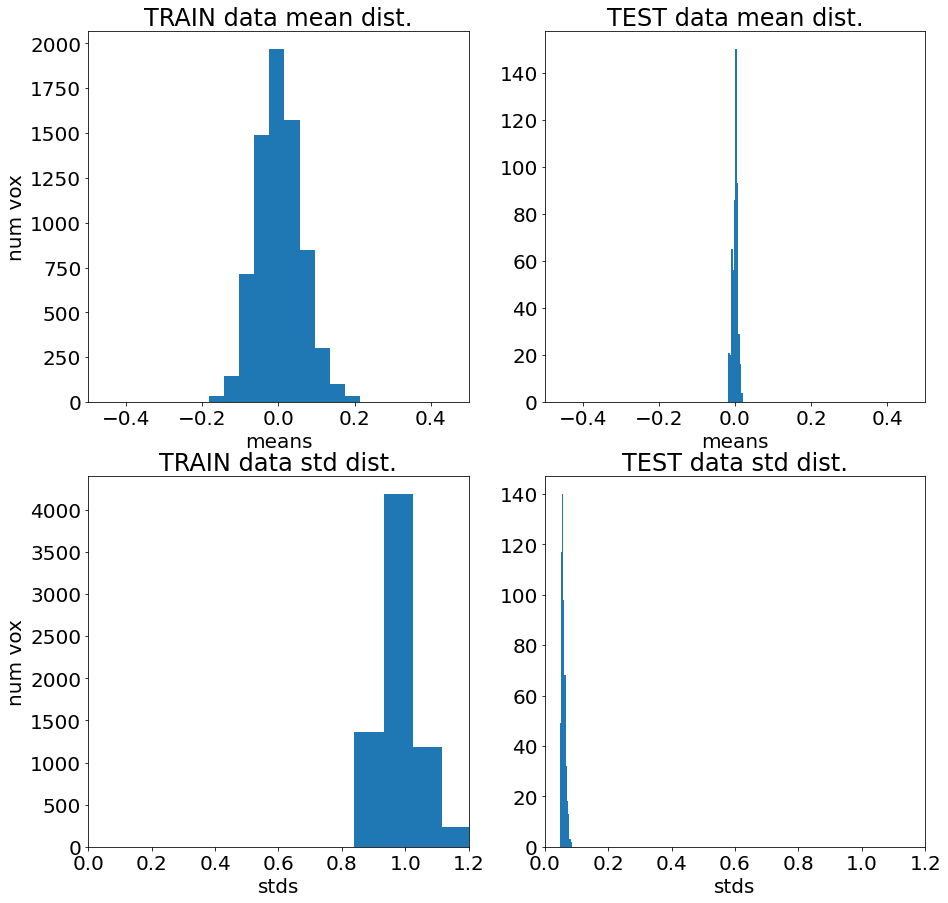

In [8]:
# look at distribution of means
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.ylabel("num vox")
plt.xlabel("means")
#train data
plt.hist(trn_data_nonan.mean(1));
plt.xlim([-0.5,0.5])
plt.title("TRAIN data mean dist.")
plt.subplot(2,2,2)
plt.xlabel("means")
#test data
plt.hist(test_data_ave_nonan.mean(1))
plt.xlim([-0.5,0.5])
plt.title("TEST data mean dist.")

# standard deviations
plt.subplot(2,2,3)
#train
plt.hist(trn_data_nonan.std(1));
plt.xlim([0,1.2])
plt.ylabel("num vox")
plt.xlabel("stds")
plt.title("TRAIN data std dist.")
plt.subplot(2,2,4)
#testing
plt.hist(test_data_ave_nonan.std(1))
plt.xlim([0,1.2])
plt.xlabel("stds")
plt.title("TEST data std dist.")
plt.savefig("./Fig1.png",format="png")

We can see above the the training data is roughly zscored (note that in the paper the zscoring is performed for each run separately whereas here we performed it across all runs).

Test data has mean around 0, but std is clearly nowhere near 1.

Let's fix that.

### Zscore the test data

In [9]:
# z-scoring from scipy - always use existing implementaions if possible!
from scipy.stats import zscore

In [10]:
## Zscore the test data
test_data_ave_nonan = zscore(test_data_nonan,axis=0).mean(1)


# Load the stimululs data

The stimulus data in the repository consists of the movie frames.

The whole thing about building encoding models is to extract some interesting features from the high dimensional data and see if and how these are related to the brain response. A bit like feature engineering.

One of the key contributions of the paper is the introduction of the Motion Energy (ME) features. These are spatiotemporal Gabors applied at different frequencies and scales. If you are interested in the details have a look at the supporting information of the paper.

You can compute the motion energy features by putting the raw stimulus through the ME computation, for which MATLAB code is available [here](https://github.com/gallantlab/motion_energy_matlab).

For your convenience I have pre-computed the features and put them up on [figshare](https://figshare.com/s/7a0e82ae48a7edf48216).

Let's load them.


In [11]:
# My ME estimates are here
ME_fldr = "../Nishimoto2011Data/" #path/to/ME/features

In [12]:
# training
fl_typ ="Stimuli_trn_luminance_Gabor_log_downsamp_zscr.mat" 
with h5py.File(ME_fldr + fl_typ,'r') as ME_stim_fl:
    ME_stim_trn = ME_stim_fl.get("S_fin")[()].T

# testing
fl_typ ="Stimuli_val_luminance_Gabor_log_downsamp_zscr.mat" 
with h5py.File(ME_fldr + fl_typ,'r') as ME_stim_fl:
    ME_stim_test = ME_stim_fl.get("S_fin")[()].T
    
# samples should match with the neural data
tmps = (f'shape of training data is {ME_stim_trn.shape},\
\nshape of test data is {ME_stim_test.shape}')
print(tmps)

shape of training data is (7200, 6555),
shape of test data is (540, 6555)


The shape of ME_stim_test and ME_stim_trn reflects samplesXfeatures. The 6555 features consists of passing the images through a set of spatio temporal Gabor wavelets with different centers, spatial frequencies, temporal frequencies and orientations.

Now we are ready to built a model that takes the ME as inputs and predicts brain responses - our encoding model!

# The encoding model

## The secret
Our encoding model is linear (mic drop).

That is, we are going to model the response at voxel i time t ( $r_{it}$ ) as a linear functions of the stimulus (S, in our case the 6555-dimensional motion energy features) at times $t-k$ to $t-p$ (delays). k and p determine how far back we look in order to predict the neural activity.

$$r_t^i = \sum_{d=p}^{k}S_{t - d} w_{id}$$

The objective is to estimate $w_{id}$ for each voxel and delay.

## What delays should we use?
fMRI does not reflect direct neuronal activity. Instead, fMRI measures what is known as BOLD (Blood-oxygen-level-dependent). BOLD actually reflects changes in oxygenated and deoxgenated blood.

The theory goes that as neurons start working they use up oxygen and this is reflected in the relative levels of oxygenated and deoxgenated blood. This response is delayed - the BOLD signal peaks ~2-6 seconds *after* the neurons start working.

In the paper they used delays of 3 to 6 seconds, so lets go with that.

## Regularization
You are probably thinking that with a 26,220 = 6555*4 (t-3 to t-6) dimensional feature vector and only 7200 samples we are going to have issues, and you are right. To deal with this we will use regularization. In the paper they used L1, but here I will use L2, aka ridge regression. In my informal conversations with Shinji Nishimoto about this I learned that L1 can give slightly better results. However, the difference is small and I have very nice code for ridge cross validation ;).

## Fitting the encoding model
sklearn and other popular packages all support ridge regressions. I have used them in the past and they work perfectly fine.

However, [Alex Huth](http://alexghuth.com/) developed his own implementation which is optimized for this kind of thing. In particular the cross validation procedure uses some tricks making it much quicker than out-of-the-box sklearn (though I admit I never benchmarked it). You can get it from [here](https://github.com/alexhuth/ridge).

In [13]:
import sys
sys.path.insert(0, '/mount/nfs/drorcohen/pystuff/') #path/to/ridge/package/
from ridge import ridge_corr, bootstrap_ridge
from ridge.ridge import ridge as fit_ridge
from ridge import utils as ridge_utils

The package includes some utilities to stack the stimulus across the desired delays.
That is, take stimulus at times t-3,t-4,t-5 and t-6 and stack them into a 4*6555 long vector

In [14]:
# stack the Stimulus for the selected delays
min_delay = 3 #inclusive
max_delay = 6 #inclusive
delays=np.arange(min_delay,max_delay+1)
# train data
ME_stim_trn_dly = ridge_utils.make_delayed(ME_stim_trn,delays)
# test data
ME_stim_test_dly = ridge_utils.make_delayed(ME_stim_test,delays)




### Trimming the data

Before fitting we are going to drop some data. The first few samples from each fMRI run reflect activity from some time before the experiment started (due to the BOLD delay). In addition, the first few samples may be a bit noisy (or non-steady) and its common practice to drop some. In the paper they drop the first six samples of each run.

In [15]:
vols_to_drop = 6
vols_to_drop_inds = np.arange(vols_to_drop)

# training data has 12 blocks of 600s
num_runs = 12
# size of each run
blk_sz = trn_data_nonan.shape[0]//num_runs
#offsets for each run
trn_block_multipliers = np.arange(num_runs)*blk_sz
#use broadcasting to get the inds
trn_inds_to_drp = (vols_to_drop_inds[np.newaxis,:]+trn_block_multipliers[:,np.newaxis]).flatten()

#will create a mask to drop these volumes
tmp_mask = np.ones(trn_data_nonan.shape[0],dtype=bool)
tmp_mask[trn_inds_to_drp] = False

#drop them
trn_data_nonan_dly = trn_data_nonan[tmp_mask,:]

# do the same to the stimulus
ME_stim_trn_dly = ME_stim_trn_dly[tmp_mask,:]



The test data was recorded in one run, so we only need to drop the first 6 samples there.

However, the test data consists of 9 chunks of 60s movies. The presentation of these movies was randomized for each repeat. For example during the first presentation of the test data the order of the movies may have been [0,3,5,8,2,7,9,1,4,6], the second presentation [9,5,6,3,1,8,7,4,2,0] etc.

Thankfully, these have already been aligned in the supplied data. However, due to the BOLD delay, the first few samples at the start of each movie actually correspond to the movie preceding it, and we don't know what that was. To get passed this we will also remove the first 6 samples of each movie (same as in the paper).

In [16]:
# recycle the code from above
num_movies = 9 #
blk_sz = test_data_ave_nonan.shape[0]//num_movies
test_block_multipliers = np.arange(num_movies)*blk_sz
#use broadcasting to get the inds
test_inds_to_drp = (vols_to_drop_inds[np.newaxis,:]+test_block_multipliers[:,np.newaxis]).flatten()
tmp_mask = np.ones(test_data_ave_nonan.shape[0],dtype=bool)
tmp_mask[test_inds_to_drp] = False
test_data_ave_nonan_dly = test_data_ave_nonan[tmp_mask,:]
ME_stim_test_dly = ME_stim_test_dly[tmp_mask,:]

### Finally, actually fitting the model

#### Parameters
Finally we can fit the encoding model. We will use cross validation to estimate the regularization parameters.

We will use the very convenient *bootstrap_ridge* function to do the cross validation for us and fit the model. Here are the important bits from the docstring:

____

bootstrap_ridge(
    Rstim,
    Rresp,
    Pstim,
    Presp,
    alphas,
    nboots,
    chunklen,
    nchunks,
    corrmin,
    single_alpha,
    use_corr,...)

Uses ridge regression with a bootstrapped held-out set to get optimal alpha for each response. The best alpha for each response will be
averaged across the bootstraps to estimate the best alpha for that response.

<u>Parameters<u>


Rstim : array_like, shape (TR, N)
    Training stimuli with TR time points and N features. Each feature should be Z-scored across time.

Rresp : array_like, shape (TR, M)
    Training responses with TR time points and M different responses (voxels, neurons, what-have-you).
    Each response should be Z-scored across time.

Pstim : array_like, shape (TP, N)
    Test stimuli with TP time points and N features. Each feature should be Z-scored across time.

Presp : array_like, shape (TP, M)
    Test responses with TP time points and M different responses. Each response should be Z-scored across
    time.

alphas : list or array_like, shape (A,)
    Ridge parameters that will be tested. Should probably be log-spaced. np.logspace(0, 3, 20) works well.

nboots : int
        The number of bootstrap samples to run. 15 to 30 works well.

chunklen : int
        On each sample, the training data is broken into chunks of this length. This should be a few times
        longer than your delay/STRF. e.g. for a STRF with 3 delays, I use chunks of length 10.

nchunks : int
        The number of training chunks held out to test ridge parameters for each bootstrap sample. The product
        of nchunks and chunklen is the total number of training samples held out for each sample, and this
        product should be about 20 percent of the total length of the training data.

corrmin : float in [0..1], default 0.2
        Purely for display purposes. After each alpha is tested for each bootstrap sample, the number of
        responses with correlation greater than this value will be printed. For long-running regressions this
        can give a rough sense of how well the model works before it's done.


single_alpha : boolean, default False
        Whether to use a single alpha for all responses. Good for identification/decoding.

use_corr : boolean, default True
        If True, this function will use correlation as its metric of model fit. If False, this function
        will instead use variance explained (R-squared) as its metric of model fit. For ridge regression
        this can make a big difference -- highly regularized solutions will have very small norms and
        will thus explain very little variance while still leading to high correlations, as correlation
        is scale-free while R**2 is not.

<u>Returns<u>


wt : array_like, shape (N, M)
If [return_wt] is True, regression weights for N features and M responses. If [return_wt] is False, [].

corrs : array_like, shape (M,)
validation set correlations. Predicted responses for the validation set are obtained using the regression

weights: pred = np.dot(Pstim, wt), and then the correlation between each predicted response and each
column in Presp is found.

alphas : array_like, shape (M,)
The regularization coefficient (alpha) selected for each voxel using bootstrap cross-validation.

bootstrap_corrs : array_like, shape (A, M, B)
Correlation between predicted and actual responses on randomly held out portions of the training set,
for each of A alphas, M voxels, and B bootstrap samples.

valinds : array_like, shape (TH, B)    

___

Lets specify the cross-validation parameters.

In [17]:
# this will keep us informed as training proceeds
import logging
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                    level=logging.INFO,
                    stream=sys.stdout)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# These are all the regularization parameter (alpha) values we'll check
alphas = np.logspace(1, 4, 40)
# number of times we will do the cross validation.
# These would typically be 15-40, but that takes a while.
# For getting the gist only you can set it to 2, but that gives worse results.
nboots = 2#20

# the cross validation works by getting blocks of contiguous data (as opposed to each sample independently).
# This parameter specifies how long we want these blocks to be. Alex Huth recommends having this 3-4 times the delay. I'll go with four
chunklen = 4 * delays[-1] #

# % of hold out data for testing.
pct_val = 0.1 #10%, same as paper
# the hold out data is specified in number of chunklengs to use. Lets calculate that
# pct_val*(Total number of data)//chunklen.
nchunks_val = int((pct_val)*trn_data_nonan_dly.shape[0]//chunklen)

# What measure we will use to assess the fit.
# Classically this is the MSE, but in fMRI studies we often use the correlation (we can argue about this elsewhere).
use_corr = True

# the logger will tell us how many voxels are above this value.
# If cross test is works, this should increase, reach a maximum, and then decrease
corrmin = 0.2

# use separate alpha for each voxel. The alternative is to use the same alpha for all voxels
single_alpha = False

cv_p = {'alphas':alphas,
        'nboots':nboots,
        'chunklen':chunklen,
        'nchunks':nchunks_val,
        'use_corr':use_corr,
        'single_alpha':single_alpha}  

print(cv_p)

{'alphas': array([   10.        ,    11.93776642,    14.2510267 ,    17.0125428 ,
          20.30917621,    24.24462017,    28.94266125,    34.55107295,
          41.24626383,    49.23882632,    58.78016072,    70.17038287,
          83.76776401,   100.        ,   119.37766417,   142.51026703,
         170.12542799,   203.09176209,   242.44620171,   289.42661247,
         345.51072946,   412.46263829,   492.38826317,   587.80160723,
         701.70382867,   837.67764007,  1000.        ,  1193.77664171,
        1425.1026703 ,  1701.25427985,  2030.9176209 ,  2424.46201708,
        2894.26612472,  3455.10729459,  4124.6263829 ,  4923.88263171,
        5878.01607227,  7017.0382867 ,  8376.77640068, 10000.        ]), 'nboots': 2, 'chunklen': 24, 'nchunks': 29, 'use_corr': True, 'single_alpha': False}


#### Finally, finally, actually fitting the encoding model                          


In [18]:
wt, corr, valphas, bscorrs, valinds = bootstrap_ridge(ME_stim_trn_dly, # training set stimuli
                                              trn_data_nonan_dly, # training set bold response
                                              ME_stim_test_dly, # test set stimuli 
                                              test_data_ave_nonan_dly, # test bold response
                                              **cv_p)



2020-08-03 14:08:54,441 | INFO : Selecting held-out test set..
2020-08-03 14:08:55,601 | INFO : Doing SVD...
2020-08-03 14:09:48,248 | INFO : Dropped 0 tiny singular values.. (U is now (6432, 6432))
2020-08-03 14:09:48,251 | INFO : Training stimulus has LSV norm: 5790.070
2020-08-03 14:10:01,390 | INFO : Average difference between actual & assumed Prespvar: -0.000
2020-08-03 14:10:03,589 | INFO : Training: alpha=10.000, mean corr=0.01649, max corr=0.57239, over-under(0.20)=911
2020-08-03 14:10:05,509 | INFO : Training: alpha=11.938, mean corr=0.01671, max corr=0.57801, over-under(0.20)=939
2020-08-03 14:10:07,586 | INFO : Training: alpha=14.251, mean corr=0.01699, max corr=0.58498, over-under(0.20)=957
2020-08-03 14:10:09,524 | INFO : Training: alpha=17.013, mean corr=0.01735, max corr=0.59339, over-under(0.20)=1007
2020-08-03 14:10:11,792 | INFO : Training: alpha=20.309, mean corr=0.01781, max corr=0.60317, over-under(0.20)=1048
2020-08-03 14:10:13,898 | INFO : Training: alpha=24.245,

**Probs a good idea to save righ around here....**

In [19]:
# tmp save of the model, to avoid training again if/when it crashes
# np.savez("./trained_model.npz"
#          wt=wt,
#          corr=corr,
#          testphas=testphas,
#          bscorrs=bscorrs,
#          testinds=testinds
#         )

# load
# with np.load("./trained_model_09072020%s.npz"%sn_data_typ[-12:-4]) as f:
#     wt = f['wt']
#     corr = f['corr']
#     testphas = f['testphas']
#     bscorrs = f['bscorrs']
#     testinds = f['testinds']

### Figure 2 - check the cross validation

If the cross validation identified the peak performance then we should see a clear maximum for some alpha value.

For simplicity we will average across all voxels when checking.

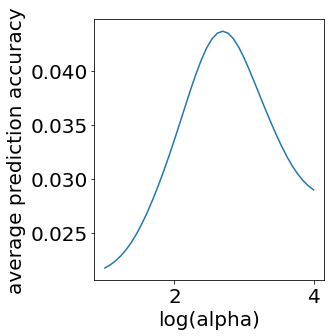

In [20]:
# peak in this graph confirms cross validation identified optimal values
plt.figure(figsize=(5,5))
plt.plot(np.log10(alphas),np.mean(bscorrs,axis=(1,2)))
plt.ylabel("average prediction accuracy")
plt.xlabel("log(alpha)")
plt.tight_layout()
plt.savefig("./Fig2.png",format="png")

### Check - prediction accuracy at two different ROIs

Let's also look at how the prediction accuracy differs between different brain areas.
We will look at

- V1 - the earliest cortical stage of visual processing and
- V3 - a higher level of visual processing.

Since the ME features are relatively low level (Gabors), I would expect prediction accuracy to be higher in V1 compared to V3. Let's see.

#### Figure 3 - encoding accuracy in V1 and V3

In [21]:
roi1 = 'v1lh' #v1, left hemisphere
roi2 = 'v3lh' #v3, left hemisphere

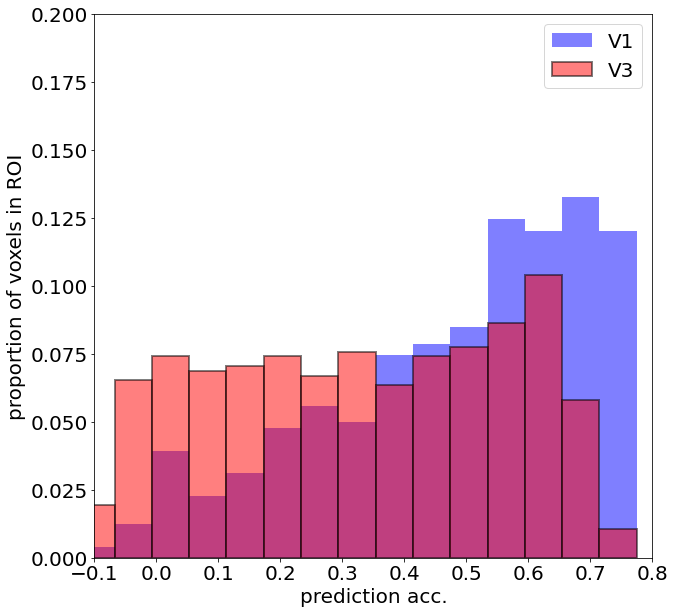

In [22]:
f,ax = plt.subplots(1,1,figsize=(10,10))
roi2chk = roi_dict_nonans[roi1].flatten().astype(np.bool_)
corrs2plt = corr[roi2chk]
#use this to normalize the hist to 1
weights = np.ones_like(corrs2plt) / len(corrs2plt)
counts_bins=ax.hist(corrs2plt,weights=weights,alpha=0.5,color="blue",bins=15);
ax.set_xlim([-0.1,0.8])
ax.set_ylim([0,0.2])
ax.set_ylabel("proportion of voxels in ROI")
ax.set_xlabel("prediction acc.")

roi2chk = roi_dict_nonans[roi2].flatten().astype(np.bool_)
corrs2plt = corr[roi2chk]
weights = np.ones_like(corrs2plt) / len(corrs2plt)
ax.hist(corrs2plt,weights=weights,alpha=0.5,color="red",edgecolor="k",linewidth=2,bins=counts_bins[1]);
ax.set_xlabel("prediction acc.")
plt.legend(["V1","V3"],fontsize=20)
# plt.ylabel
plt.savefig("./Fig3.png",format="png")

As you can see V1 has more voxels with higher accuracy than V3, inline with our expectation. 

# Decoding

## Gist
The idea behind the decoding approach is simple - we invert the decoding model.

Mathematically, what we will do here is the same as the *maximum a posterior estimate*(MAP) under Gaussian assumptions.

Conceptually, you can think of it as feeding different inputs to the encoding model and choosing the one that best matches the observed brain response.

## Choosing meaningful voxels
Many parts of the brain are not concerned with motion energy and the prediction accuracy in these parts is low. There is no point using those brain areas in decoding.

Here I will choose the best 2000 voxels as assessed using the cross validation accuracy (in the paper they restrict the selection to V1, V2 and V3, but that's not critical). There would be a bit of double dipping if I chose the best voxels using the test set.

In [23]:
# number of voxels we will use for reconstruction
N=2000

#cross val predictions accuracy for each alpha
mean_corr_acrossboot = bscorrs.mean(-1)
# location of best alpha for each voxel
best_corr_ind = np.argmax(mean_corr_acrossboot,0)
# get the scores for each voxel at their best alpha
num_voxels = mean_corr_acrossboot.shape[1]
best_corrs_forvox = mean_corr_acrossboot[best_corr_ind,np.arange(num_voxels)]
srt_corrs = np.argsort(best_corrs_forvox)
# the best performing voxels
topN = srt_corrs[-N:]


## Shrunk covariance estimate

As I mentioned decoding is based on trying out different candidate inputs and choosing the one that "best" matches the observed response under the encoding model.

So how do we define "best"? With MAP under Gaussian assumptions, "best" means likelihood, which is proportional to the mahalanobis distance (homework - will there be a difference if we used loglikelihood rather than mahalanobis?).

For observed and estimated brain responses $r$ and $\hat{r}$ the mahalanobis distance is

$\sqrt{(r-\hat{r})\Sigma^{-1}(r-\hat{r})^T}$

We get $\hat{r}$ using our encoding model. $\Sigma$ is the residual covariance matrix and we need to estimate it. In the paper and here we will use a shrunk estimate.

The basic idea of shrinking is to increase the "strength" of the leading diagonal, thereby making the matrix better conditioned. There are different approaches for estimating the shrinkage (L1, L2, heuristic based etc.). Here I will go with the sklearn's L2 shrinkage implementation.

The form of this estimate is:

$\Sigma_{shrunk} = (1-\alpha_{decode})\hat{\Sigma} + \alpha_{decode}\frac{Tr\hat{\Sigma}}{p}Id$

You can read more about this shrunk estimate [here](https://scikit-learn.org/stable/modules/covariance.html).

We will estimate $\alpha_{decode}$ using a second cross validation.

In [24]:
from sklearn.covariance import shrunk_covariance

As mentioned we will also want a function of calculating the mahalanobis. Scipy has an inbuilt one. However it is painfully slow. Here we have no choice but to reinvent the wheel (or rather steal a reinvented wheel from stackoverflow. Same diff)

In [25]:
def faster_mahalanobis(x,y,VI):
    """Faster mahalanobis than scipy. Calculates distance between all pairs of x and y.

        Args:
            x (array): Array of vectors, m sambles by k features.
            y (array): Array of vectors, n sambles by k features.
            VI (array): inverse of covariancce matrix used in calculation

        Returns:
            Distance between all pairs in x and y. The array is m by n, distance between x_i and y_j is stored [i,j]

    """
    dist = np.zeros((x.shape[0],y.shape[0]))
    for ind in range(x.shape[0]):
        e = x[ind,:] - y # broadcasting. We can get rid of first for loop as well but that would be more difficult to read
        # thank you stackoverflow https://stackoverflow.com/questions/27686240/calculate-mahalanobis-distance-using-numpy-only
        D = np.sqrt(np.sum(np.dot(e,VI) * e, axis = 1)) 
        dist[ind,:]=D
    return dist



## Getting the MAP
This handy function gets the MAP for us - simply choosing the minimum across a distance array. It also calculates the average accuracy of the MAP estimate. The ground truth is very simple - np.arange(len(numsamples)

In [26]:
# this utility function computes the average map estimate given a dist matrix
def MAP_score(dist,axis=1):
    
    """Get the identification accuracy using maximum a posteriori

        Args:
            dist (array): An array of distances between two sets of vectors
            axis (int): The axis along which the predictions are made. Default is 1.
            This means that the distance representes testues between the actual observed testues in rows, 
            and a bunch of candidate predictions that were used with matching inputs. 

        Returns:
            The average accuracy of the MAP

    """
    # where is the MAP estimate
    MAPs = np.argmin(dist,axis=axis)
    # does it match with the correct testue - i.e. does it lie along the diagonal? 
    ave_score = (np.arange(len(MAPs)) == MAPs).mean()
    return ave_score, MAPs

## Cross validation to estimate the shrinkage parameter


In [27]:
# the shrinkage estimates we will assess
shrinkages = np.linspace(0.3, 0.9, 12)

#keep results here
scores = np.zeros((nboots,len(shrinkages)))




We will carry out the cross validation using the same folds as the encoding model. This is not critical here, but in general care needs to be taken to ensure that information is not somehow leaking across the folds.

In [28]:
# use the same CV parameters as the ridge reg
allinds = np.arange(trn_data_nonan_dly.shape[0])
valinds = np.array(valinds)

In [29]:
# Here we manually reproduce the ridge cross val
for split in range(nboots):
    print(f'split number {split}')
    held_inds = valinds[split,:]
    not_held_inds = np.array(list(set(allinds)-set(held_inds)))
        

    # this splits train and test data
    split_train = trn_data_nonan_dly[np.ix_(not_held_inds,topN)]
    split_test = trn_data_nonan_dly[np.ix_(held_inds,topN)]
    split_ME_train = ME_stim_trn_dly[not_held_inds,:]
    split_ME_test = ME_stim_trn_dly[held_inds,:]
    
    # retrain the model using the optimal alpha
    split_wt = fit_ridge(split_ME_train, split_train, valphas[topN])
#     Ridge_obj = ridge(testphas[topN], fit_intercept=False, solver='svd')
#     split_wt=Ridge_obj.fit(split_ME_train,split_train).coef_.T
    
    #  model predictions for this split
    split_train_preds = np.dot(split_ME_train,split_wt)  
    split_test_preds = np.dot(split_ME_test,split_wt)  
    
    #this split train residuals
    split_train_error = split_train - split_train_preds
    # this split covariance
    split_cov =  np.cov(split_train_error,rowvar=False)
    
    # try each shrinkage
    print(f'checking shrinkage weight:')
    for cntr2,shrinkage in enumerate(shrinkages):

            #ShrunkCovariance(shrinkage=shrinkage).fit(split_train_error)# split_cov + shrinkage*np.eye(N)
            tmp = shrunk_covariance(split_cov, shrinkage=shrinkage)
            # the corresponding precision
            VI =np.linalg.inv(tmp)
            # get the distance based on this precision
            # The distane from arg1_i to arg2_j is stored in dist[i,j], which here is observedXpredicted 
            dist = faster_mahalanobis(split_test,split_test_preds,VI=VI)
            # get the identification score for this 
            ave_score, MAPs = MAP_score(dist,axis=1)
            print(f'shrink test: {shrinkage:.4f}, score: {ave_score:.4f}')
            scores[split,cntr2] = ave_score
    print("\n")

split number 0
checking shrinkage weight:
shrink test: 0.3000, score: 0.4080
shrink test: 0.3545, score: 0.4181
shrink test: 0.4091, score: 0.4382
shrink test: 0.4636, score: 0.4483
shrink test: 0.5182, score: 0.4583
shrink test: 0.5727, score: 0.4641
shrink test: 0.6273, score: 0.4698
shrink test: 0.6818, score: 0.4784
shrink test: 0.7364, score: 0.4756
shrink test: 0.7909, score: 0.4641
shrink test: 0.8455, score: 0.4511
shrink test: 0.9000, score: 0.4267


split number 1
checking shrinkage weight:
shrink test: 0.3000, score: 0.3966
shrink test: 0.3545, score: 0.4138
shrink test: 0.4091, score: 0.4210
shrink test: 0.4636, score: 0.4325
shrink test: 0.5182, score: 0.4310
shrink test: 0.5727, score: 0.4296
shrink test: 0.6273, score: 0.4267
shrink test: 0.6818, score: 0.4368
shrink test: 0.7364, score: 0.4282
shrink test: 0.7909, score: 0.4296
shrink test: 0.8455, score: 0.4124
shrink test: 0.9000, score: 0.3822




**Good idea to save here...**

In [30]:
# save them cause the above can take a bit of time
# np.savez("./shrinkage_estimates.npz",
#          num_splits=nboots,
#          shrinkages=shrinkages,
#          scores=scores)
#          test_size=test_size,
#          train_size=train_size,
#          random_states = random_states)

In [31]:
# load
# with np.load("./shrinkage_estimates.npz") as f:
#     num_splits = f['num_splits']
#     shrinkages = f['shrinkages']
#     scores = f['scores']

### Figure 4 Check the shrinkage cross validation
Do we get a maximum decoding at some intermediate value?


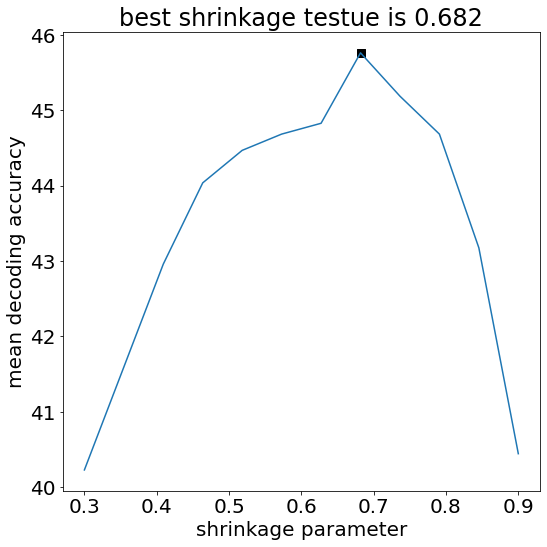

In [32]:
plt.figure(figsize=(8,8))
plt.xlabel("shrinkage parameter")
plt.ylabel("mean decoding accuracy")
scores_mean = scores.mean(0)*100
plt.plot(shrinkages,scores_mean);
best_shrinkage_ind = np.argmax(scores_mean)
best_shrink = shrinkages[best_shrinkage_ind]
plt.scatter(best_shrink,scores_mean[best_shrinkage_ind],marker="s",s=60,color="black")
plt.title(f"best shrinkage testue is {best_shrink:.3f}")
plt.tight_layout()
plt.savefig("./Fig4.png",format="png")

# Test set results (reproducing some figures from the paper)

Now that we have estimated the shrinkage parameter, we can calculate residual covariance matrix across the entire training set

In [33]:
# Compute the residual covariance matrix for entire training data
train_preds = np.dot(ME_stim_trn_dly,wt[:,topN]) #wt was calculated way back in the ridge cross val 
train_obs = trn_data_nonan_dly[:,topN]
emp_cov =  np.cov(train_obs-train_preds, rowvar=False)
emp_cov_shrunk = shrunk_covariance(split_cov, shrinkage=best_shrink)
# the inverse
VI =np.linalg.inv(emp_cov_shrunk)

Get the test set predictions

In [34]:
test_preds = np.dot(ME_stim_test_dly,wt[:,topN])  
test_obs = test_data_ave_nonan_dly[:,topN]
num_test_samples = test_obs.shape[0]

In [35]:
# calculate the mahalanobis 
dist = faster_mahalanobis(test_obs,test_preds,VI=VI)
# MAP accuracy
test_ave_score, test_MAPs = MAP_score(dist,axis=1)


## Figure 5 - decoding results
Here we will create the same figures as Fig 3 A and B from the paper.

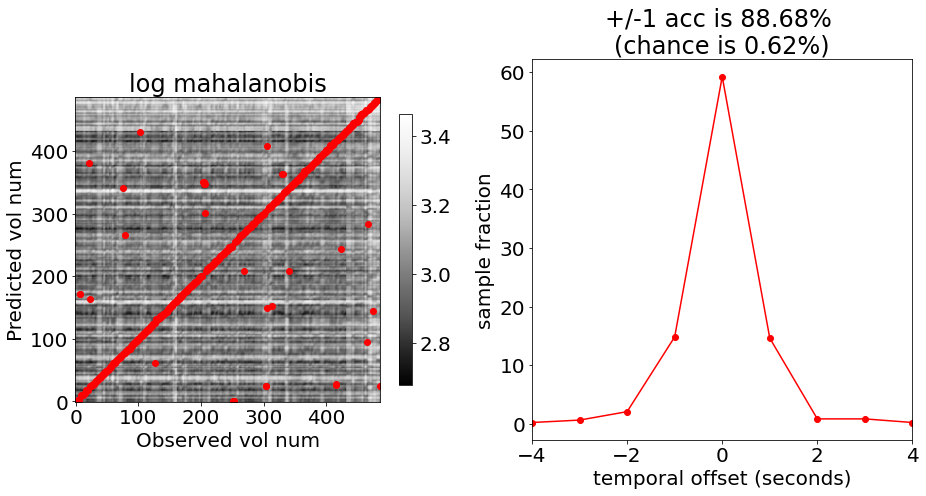

In [36]:
# Show the (log) mahalanobis between all points. 
f,ax = plt.subplots(1,2,figsize=(15,10))
im = ax[0].imshow(np.log(dist), origin='lower',cmap = "Greys_r")
# add a red circle for the MAP estimate 
ax[0].scatter(np.arange(num_test_samples),test_MAPs,marker="o",color="r")
plt.colorbar(im,ax=ax[0], shrink=0.5)
ax[0].set_ylabel("Predicted vol num")
ax[0].set_xlabel("Observed vol num")
ax[0].set_title("log mahalanobis")

# lets look at how far our estimate was from the correct one
ground_truth = np.arange(num_test_samples)
# what kind of mistakes we made, and how many of them
utests,counts = np.unique(test_MAPs-ground_truth,return_counts=True)

ax[1].plot(utests,100*counts/num_test_samples,marker="o",color="red")
ax[1].set_xlim(-4,4)
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
ax[1].set_aspect(asp)

# in the paper they report the accuracy allowing for +/- 1 errors. This is pretty reasonable because BOLD is slow and does not change too much from second to second.
acc_plus_minus_1 = 100*counts[(-1<=utests) & (utests<=1)].sum()/num_test_samples
ax[1].set_title(f'+/-1 acc is {acc_plus_minus_1:.2f}% \n(chance is {100*3/num_test_samples:.2f}%)')
ax[1].set_ylabel("sample fraction")
ax[1].set_xlabel("temporal offset (seconds)")
plt.savefig("./Fig5.png",format="png")

# Conclusion


So we saw how to decode visual experience using brain activation.
The approach is fairly simple - invert a linear forward model, but the devil is in the details.

Many of the  small steps we made above can make a big difference to performance. For example, remember the zscoring of the test set we performed way back when? Check to see what happens if we ignore that.
Remember how we chose delays of 3-6? Try a delay of 1. How about the mahalanobis? Try just using the MSE instead. 

## Extensions
### Reconstructing visual experience
What we did here is to decode visual experience as opposed to reconstruct it, which is what the paper is really about. Conceptually this is a small jump. For example to reconstruct the visual experience based on the test data all we need to do is grab the movie frames corresponding to the MAP estimates.

But what if we didn't actually know what the subject was watching? The trick here is to create a big database of movie clips and corresponding motion energy estimate (the prior). Given a set of data, we use the encoding model to rank the database and simply retrieve the best clip (MAP estimate). In the paper, they report that averaging across the best 100 clips gives better reconstruction results than the MAP.

Conceptually this is simple, but the prior is very large (in the paper they used ~18 million one-second movie clips). I don't have that on hand atm.

### Using DNNs
The Motion Energy filters work really well. Given the state of modern machine learning, it is natural to try and use features extracted by deep nets. The field is definitely moving in this direction (check out some of the work by Kamitani lab (references below)).

## Further reading

- *Encoding and decoding in fMRI*
2011, Thomas Naselarisa, Kendrick N. Kayb, Shinji Nishimotoa, and Jack L. Gallant

A great review about encoding and decoding models in fMRI.

- *Causal interpretation rules for encoding and decoding models in neuroimaging*
2015, Sebastian Weichwald, Timm Meyer, Ozan Özdenizci, Bernhard Schölkopf,
Tonio Ball c, Moritz Grosse-Wentrup a

A study explaining when and how we can use encoding and decoding models to make causal, as opposed to mere correlational, interpretations. Under appreciated study.

- *Natural speech reveals the semantic maps that tile human cerebral cortex*
2016, Alexander G. Huth, Wendy A. de Heerb, Thomas L. Griffiths, Frédéric E. Theunissena,
and Jack L. Gallanta,

Here we focused on images, in this paper Huth et al use natural speech to investigate how semantics are organized in the brain.

- *Quantitative models reveal the organization of diverse cognitive functions in the brain*
2020, Tomoya Nakai & Shinji Nishimoto

This study uses encoding and decoding to investigate how mental tasks (counting, recall, imagery etc) are organized in the brain

- *Generic decoding of seen and imagined objects using hierarchical visual features*
2017, Tomoyasu Horikawa & Yukiyasu Kamitani

A more recent decoding study using DNNs to decode visual imagery. Impressive results.